# Réalisez un dashboard
## Notebook - Test de l'API  
OpenClassrooms - Parcours Data Scientist - Projet 08  

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import os
import pickle
# import matplotlib.pyplot as plt

In [67]:
# Graphique des valeurs SHAP
def plot_shap_values(local_importance, feature_names, top_n=20):
    # Créer un DataFrame à partir des valeurs SHAP et des noms des features
    shap_values_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': local_importance})

    # Trier par la valeur absolue des valeurs SHAP et sélectionner les top N
    shap_values_df['Abs SHAP Value'] = np.abs(shap_values_df['SHAP Value'])
    shap_values_df = shap_values_df.sort_values(by='Abs SHAP Value', ascending=False).head(top_n)

    # Tracer les valeurs SHAP
    plt.figure(figsize=(10, 8))
    plt.barh(shap_values_df['Feature'], shap_values_df['SHAP Value'])
    plt.xlabel('SHAP Value')
    plt.title(f'Top {top_n} Feature importance locale (SHAP values)')
    plt.gca().invert_yaxis()
    plt.show()

In [68]:
# Graphique de comparaison des features importance locale et globale
def compare_feature_importance(local_importance, global_importance_df, top_n=20):
    # Convertir les valeurs SHAP locales en DataFrame
    local_importance_df = pd.DataFrame({'Feature': global_importance_df['Feature'], 'Local importance': local_importance})
    
    # Joindre les DataFrames d'importance locale et globale
    comparison_df = global_importance_df.set_index('Feature').join(local_importance_df.set_index('Feature'))
    
    # Trier par la valeur absolue de l'importance locale et sélectionner les top N
    comparison_df['Abs Local importance'] = np.abs(comparison_df['Local importance'])
    comparison_df = comparison_df.sort_values(by='Abs Local importance', ascending=False).head(top_n)
    
    # Tracer la comparaison
    fig, ax = plt.subplots(figsize=(10, 8))
    comparison_df[['Global importance', 'Local importance']].plot(kind='barh', ax=ax)
    ax.set_xlabel('Importance')
    ax.set_title('Comparaison de l\'importance des features (Globale vs Locale)')
    plt.gca().invert_yaxis()
    plt.show()


In [19]:
# Nombre d'exemples à tester
n_samples = 10

In [20]:
# Récupération des données de test
base_dir = os.getcwd()
df_test_path = os.path.join(base_dir, '..', '..', 'P08 - Dashboard', 'data', 'raw', 'application_test.csv')
df_test = pd.read_csv(df_test_path)

In [21]:
# Récupération du seuil de classification
threshold_path = os.path.join(base_dir, '..', 'data', 'processed', 'best_threshold.txt')
with open(threshold_path, 'r') as threshold_file:
    best_threshold = float(threshold_file.read())

In [22]:
# Sélection aléatoire de n_samples exemples
df_subset = df_test.sample(n_samples)

In [23]:
# Récupération des id clients
sk_id_curr = df_subset['SK_ID_CURR'].astype('int')

In [24]:
# Suppression des id clients
df_subset = df_subset.drop(columns='SK_ID_CURR')

In [25]:
# Remplacement des valeurs manquantes par None (JSON n'accepte pas les NaN)
df_subset =  df_subset.map(lambda x: None if pd.isna(x) else x)

In [26]:
# Conversion au format JSON
data_json = json.dumps({
    "columns": df_subset.columns.tolist(),
    "data": df_subset.values.tolist()}
)

In [33]:
# Envoi de la requête POST à l'API
heroku_url = 'https://failurescore-bc9f53f25e58.herokuapp.com/predict'
local_url = 'http://127.0.0.1:5000/predict'
response = requests.post(
    heroku_url,
    headers={'Content-Type': 'application/json'},
    data=data_json
)

In [34]:
display(response)

<Response [500]>

In [29]:
# DataFrame pour affichage des probabilités et accord ou non de crédit
predictions = pd.DataFrame({'Customer id': sk_id_curr.values.tolist(), 'Failure probability': response.json()['prediction_proba']})
predictions['Credit agreement'] = predictions['Failure probability'] < best_threshold
predictions['Failure probability'] = round(predictions['Failure probability'], 2)

In [30]:
# Affichage
display(predictions)

,Customer id,Failure probability,Credit agreement
0,161691,0.17,True
1,219608,0.18,True
2,226258,0.17,True
3,411349,0.20,True
4,108171,0.47,True
5,149969,0.25,True
6,343436,0.21,True
7,305915,0.18,True
8,292700,0.62,False
9,346414,0.49,True


In [15]:
local_importance = response.json()['feature_importance']

In [16]:
feature_names = response.json()['feature_names']

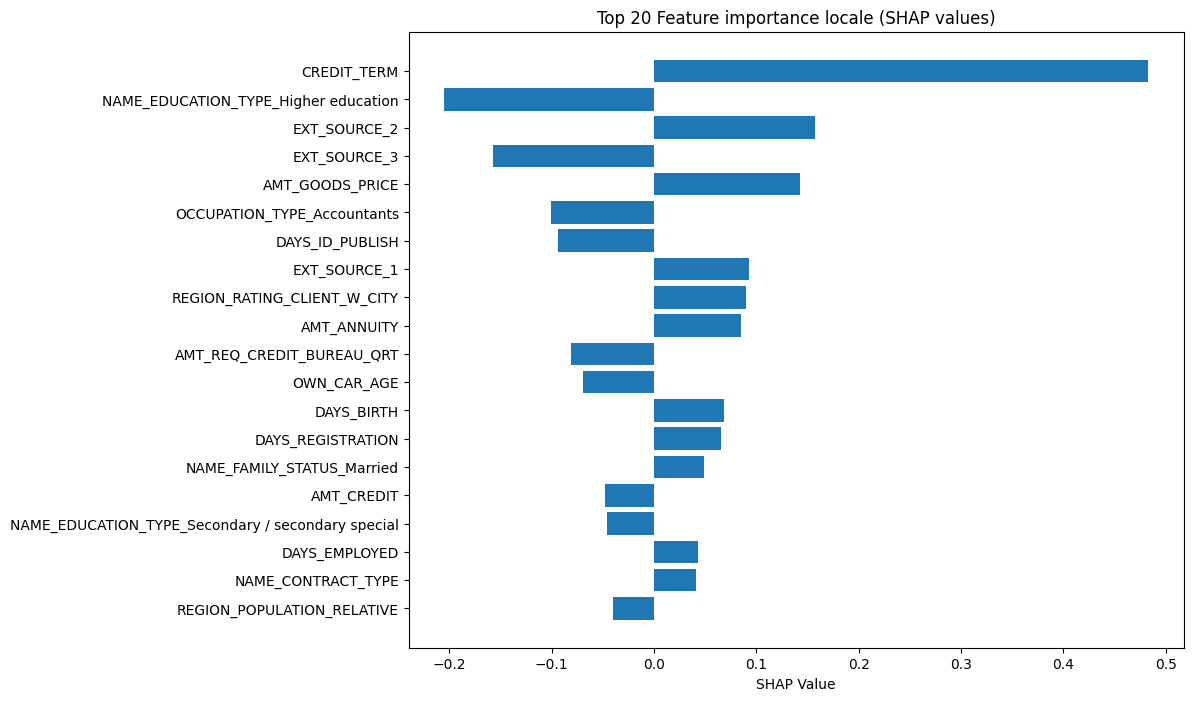

In [23]:
# Graphique feature importance locale
plot_shap_values(local_importance[0], feature_names)